import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pathlib
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]

from get_rat_data import *

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

In [283]:
ANIMAL = "W078"

ndf = pd.read_csv("/Volumes/brody/jbreda/PWM_data_scrape/W078_trials_data.csv")

vdf = get_rat_viol_data(animal_ids=[ANIMAL])
odf = get_rat_data(animal_ids=[ANIMAL])

returning viol data for ['W078']
returning full data for ['W078']


In [284]:
print(f"DATA FRAME LENS \n new: {len(ndf)} \n old: {len(odf)} \n viol: {len(vdf)}")

DATA FRAME LENS 
 new: 108475 
 old: 106662 
 viol: 53299


In [285]:
print(
    f"NUMBER OF SESSIONS \n new: {len(ndf.session_counter.unique())} \n old: {len(odf.session.unique())} \n viol: {len(vdf.session.unique())}"
)

NUMBER OF SESSIONS 
 new: 366 
 old: 379 
 viol: 200


In [286]:
ndf.columns

Index(['rat_name', 'session_date', 'session_counter', 'rig_id',
       'training_stage', 'A1_dB', 'A2_dB', 'hit_history', 'violation_history',
       'timeout_history', 'A1_sigma', 'Rule', 'ThisTrial', 'violation_iti',
       'error_iti', 'secondhit_delay', 'PreStim_time', 'A1_time', 'Del_time',
       'A2_time', 'time_bet_aud2_gocue', 'time_go_cue', 'CP_duration',
       'CenterLed_duration', 'Left_volume', 'Right_volume', 'Beta', 'RtProb',
       'psych_pairs'],
      dtype='object')

### Trial Counts

In [287]:
def add_trial_column(group):
    group["trial"] = np.arange(1, len(group) + 1)
    return group


ndf = ndf.groupby("session_counter").apply(add_trial_column).reset_index(drop=True)

Text(0.5, 1.0, 'Old Dataset')

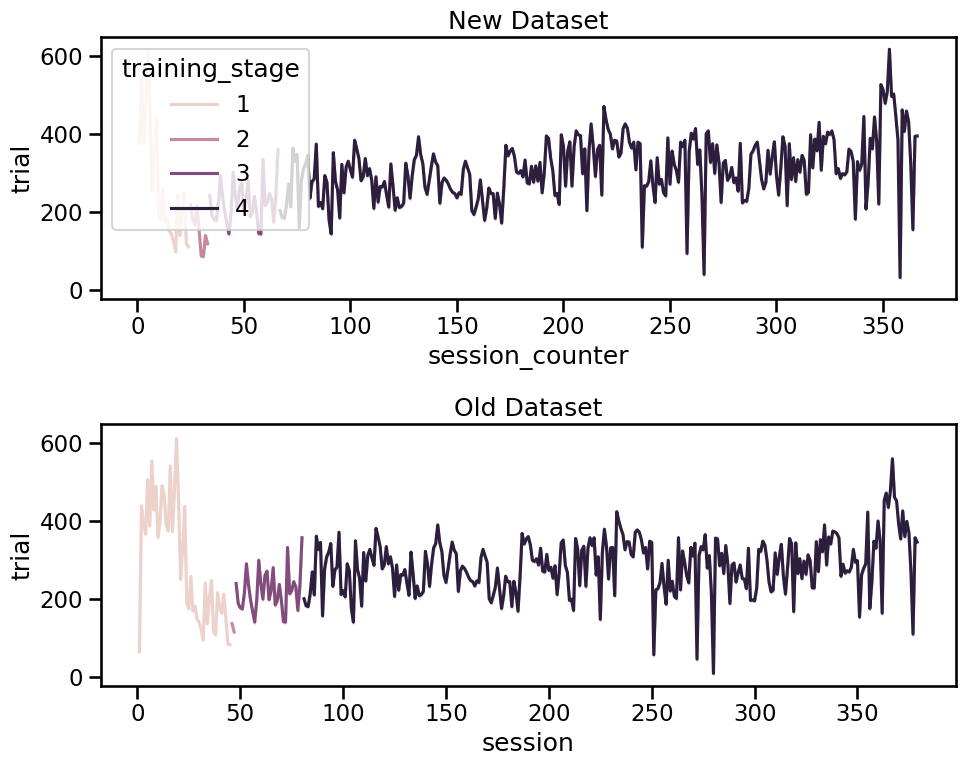

In [288]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharey=True, tight_layout=True)

sns.lineplot(
    data=ndf,
    x="session_counter",
    y="trial",
    ax=ax[0],
    hue="training_stage",
    estimator="max",
)


sns.lineplot(
    data=odf,
    x="session",
    y="trial",
    hue="training_stage_cat",
    estimator="max",
    ax=ax[1],
    legend=False,
)

ax[0].set_title("New Dataset")
ax[1].set_title("Old Dataset")

Text(0.5, 1.0, 'W078 Trial Counts Across Datasets')

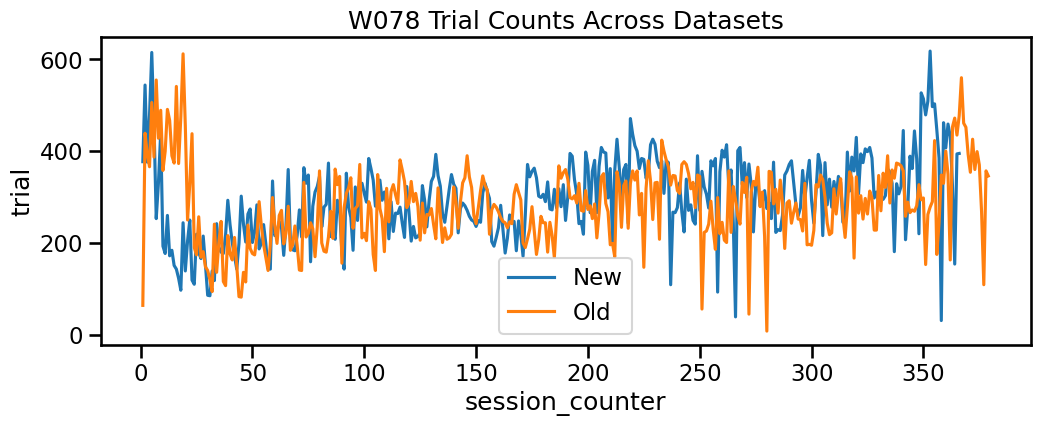

In [289]:
fig, ax = plt.subplots(
    figsize=(12, 4),
)

sns.lineplot(
    data=ndf,
    x="session_counter",
    y="trial",
    estimator="max",
    ax=ax,
    errorbar=None,
    label="New",
)
sns.lineplot(
    data=odf, x="session", y="trial", estimator="max", ax=ax, errorbar=None, label="Old"
)

plt.legend()
ax.set_title("W078 Trial Counts Across Datasets")

It looks like I can align the sessions a bit better- speicically, the max trial count that occurs for both old and new at around 600 trials and before session 50. Let figure out what those session numbers are.

In [290]:
old_session = odf.query("trial > 600 and session < 50").session.unique()
new_session = ndf.query("trial > 600 and session_counter < 50").session_counter.unique()

print(f"FOR ALIGNMENT: old sessions: {old_session}, new sessions: {new_session}")

FOR ALIGNMENT: old sessions: [19], new sessions: [5]


In [416]:
# in ndf faind aindex where trial count is max
# to doa
align_val = old_session - new_session
odf["session_align"] = odf["session"] - align_val

ndf["session"] = ndf["session_counter"] + align_val

Text(0.5, 1.0, 'W078 Trial Counts Across Datasets')

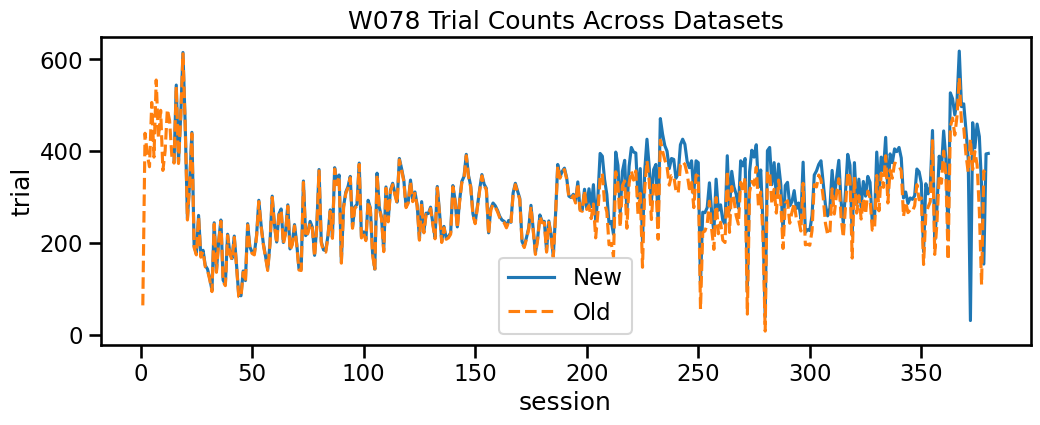

In [417]:
fig, ax = plt.subplots(
    figsize=(12, 4),
)

sns.lineplot(
    data=ndf,
    x="session",
    y="trial",
    estimator="max",
    ax=ax,
    errorbar=None,
    label="New",
)
sns.lineplot(
    data=odf,
    x="session",
    y="trial",
    estimator="max",
    ax=ax,
    errorbar=None,
    label="Old",
    ls="--",
)

plt.legend()
ax.set_title("W078 Trial Counts Across Datasets")

Text(0.5, 1.0, 'W078 Trial Counts Across Datasets')

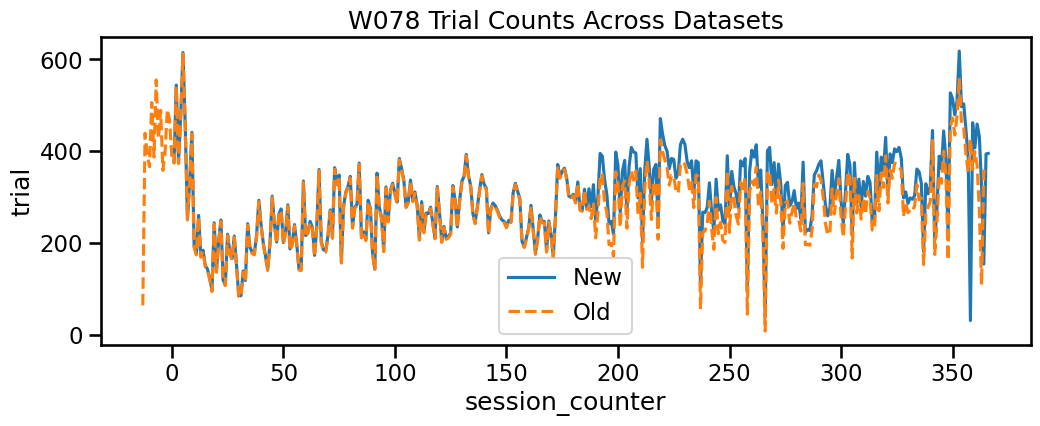

In [292]:
fig, ax = plt.subplots(
    figsize=(12, 4),
)

sns.lineplot(
    data=ndf,
    x="session_counter",
    y="trial",
    estimator="max",
    ax=ax,
    errorbar=None,
    label="New",
)
sns.lineplot(
    data=odf,
    x="session_align",
    y="trial",
    estimator="max",
    ax=ax,
    errorbar=None,
    label="Old",
    ls="--",
)

plt.legend()
ax.set_title("W078 Trial Counts Across Datasets")

Text(0.5, 1.0, 'Avg Trials/Session for W078')

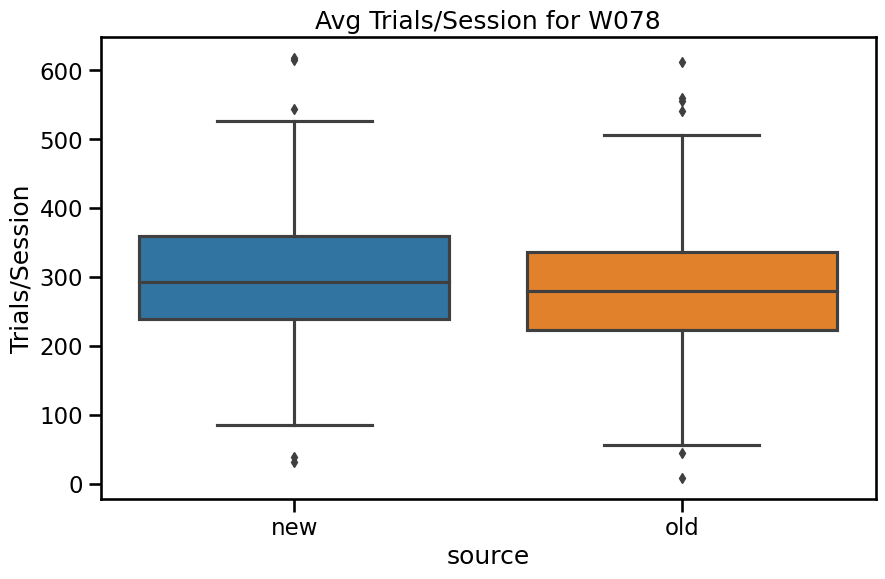

In [293]:
ndf["source"] = "new"
odf["source"] = "old"

combined_df = pd.concat(
    [
        ndf.groupby(["source", "session_counter"]).trial.max(),
        odf.groupby(["source", "session"]).trial.max(),
    ]
).reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(x="source", y="trial", data=combined_df)
plt.ylabel("Trials/Session")
plt.title("Avg Trials/Session for W078")

### Hit Rates

Text(0.5, 1.0, 'Old Dataset')

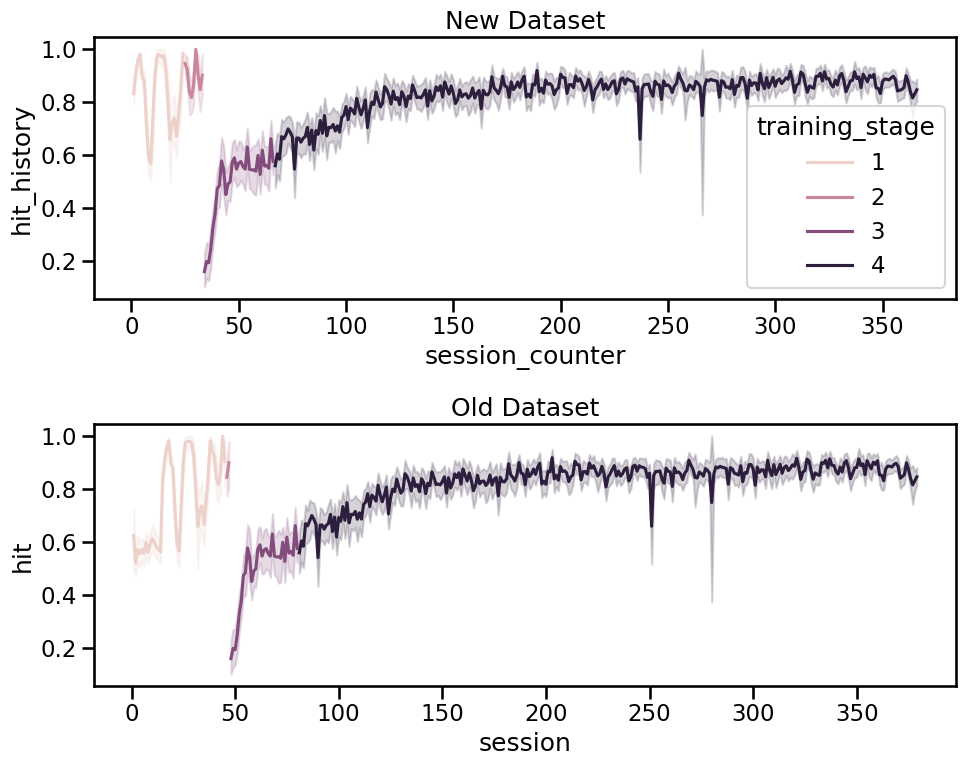

In [294]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharey=True, tight_layout=True)

sns.lineplot(
    data=ndf, x="session_counter", y="hit_history", ax=ax[0], hue="training_stage"
)


sns.lineplot(
    data=odf, x="session", y="hit", hue="training_stage_cat", ax=ax[1], legend=False
)

ax[0].set_title("New Dataset")
ax[1].set_title("Old Dataset")

Text(0.5, 1.0, 'W078 Hit Rate Across Datasets')

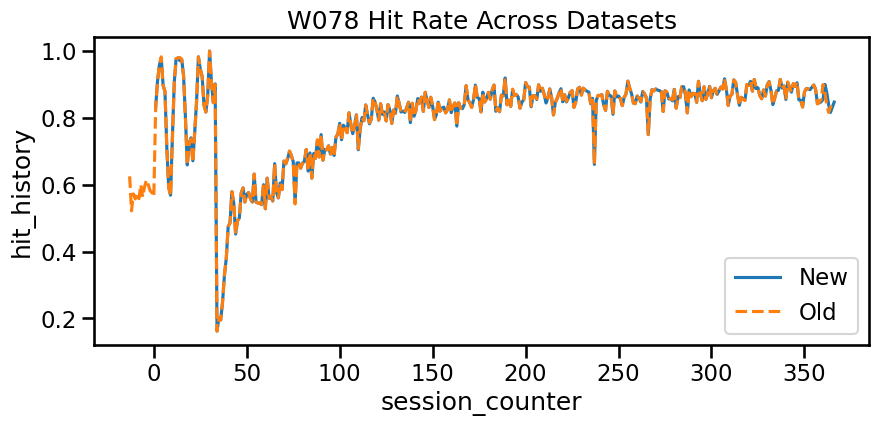

In [295]:
fig, ax = plt.subplots(
    figsize=(10, 4),
)

sns.lineplot(
    data=ndf, x="session_counter", y="hit_history", ax=ax, errorbar=None, label="New"
)
sns.lineplot(
    data=odf, x="session_align", y="hit", ax=ax, errorbar=None, label="Old", ls="--"
)

plt.legend()

plt.title("W078 Hit Rate Across Datasets")

### Violation Rates


Text(0.5, 1.0, 'Old Dataset')

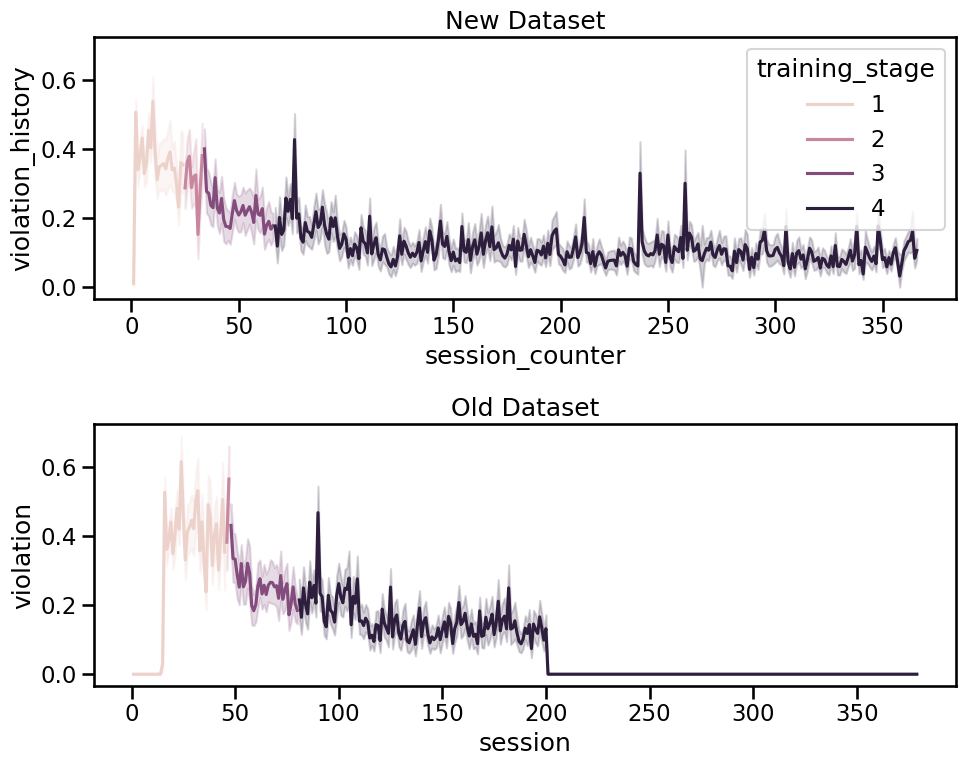

In [296]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharey=True, tight_layout=True)

sns.lineplot(
    data=ndf, x="session_counter", y="violation_history", ax=ax[0], hue="training_stage"
)


sns.lineplot(
    data=odf,
    x="session",
    y="violation",
    hue="training_stage_cat",
    ax=ax[1],
    legend=False,
)


ax[0].set_title("New Dataset")
ax[1].set_title("Old Dataset")

Text(0.5, 1.0, 'W078 Violation Rate Across Datasets')

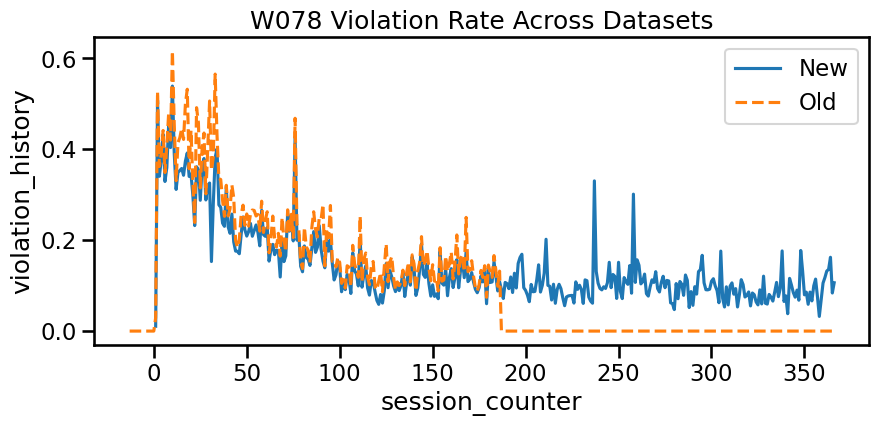

In [297]:
fig, ax = plt.subplots(
    figsize=(10, 4),
)

sns.lineplot(
    data=ndf,
    x="session_counter",
    y="violation_history",
    ax=ax,
    errorbar=None,
    label="New",
)
sns.lineplot(
    data=odf,
    x="session_align",
    y="violation",
    ax=ax,
    errorbar=None,
    label="Old",
    ls="--",
)
plt.title("W078 Violation Rate Across Datasets")

### Timeouts

Text(0.5, 1.0, 'W078 timeout history \n Session Mean: 0.04')

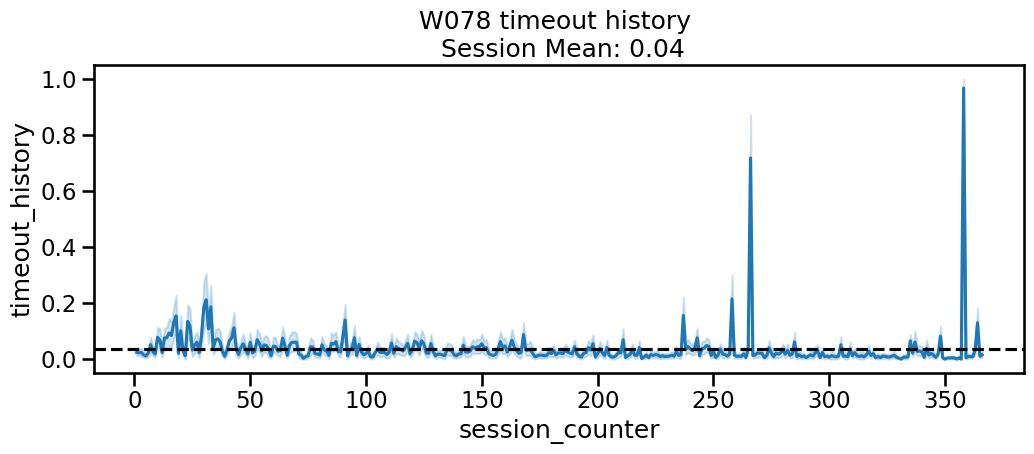

In [298]:
fig, ax = plt.subplots(
    figsize=(12, 4),
)
sns.lineplot(data=ndf, x="session_counter", y="timeout_history", ax=ax)
session_mean = ndf.groupby("session_counter").timeout_history.mean().mean()
ax.axhline(session_mean, color="k", ls="--")
plt.title(f"W078 timeout history \n Session Mean: {session_mean:.2f}")

(-0.05, 0.5)

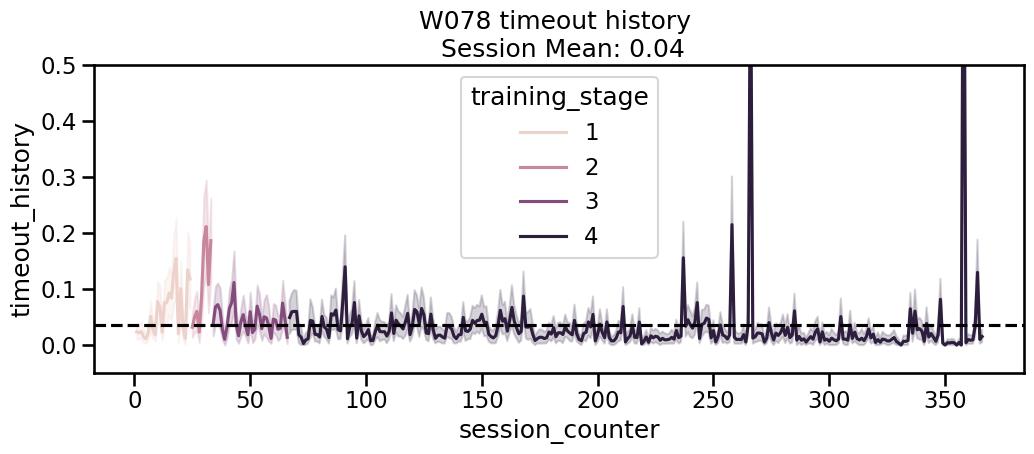

In [282]:
fig, ax = plt.subplots(
    figsize=(12, 4),
)
sns.lineplot(
    data=ndf, x="session_counter", y="timeout_history", hue="training_stage", ax=ax
)
session_mean = ndf.groupby("session_counter").timeout_history.mean().mean()
ax.axhline(session_mean, color="k", ls="--")
plt.title(f"W078 timeout history \n Session Mean: {session_mean:.2f}")
plt.ylim(None, 0.5)

In [304]:
print(f"UNIQUE TIMEOUT TIMES: {ndf.CenterLed_duration.unique()}")

UNIQUE TIMEOUT TIMES: [200]


### Timeouts & Violations 

Okay, time outs are counted in the total number of trials. Let's see if Athena was counting them as violation rates. I am going to add "violation_history" and "timout_history" together to see if it created the same violation rate as what was seen in the old df.

In [306]:
ndf["timeout_and_violation_history"] = ndf.violation_history + ndf.timeout_history
assert (
    ndf.timeout_and_violation_history.max() == 1
), "ERROR: TIMEOUT AND VIOLATION ON SAME TRIAL"

Text(0.5, 1.0, 'W078 Violation Rate + Timeout Rate')

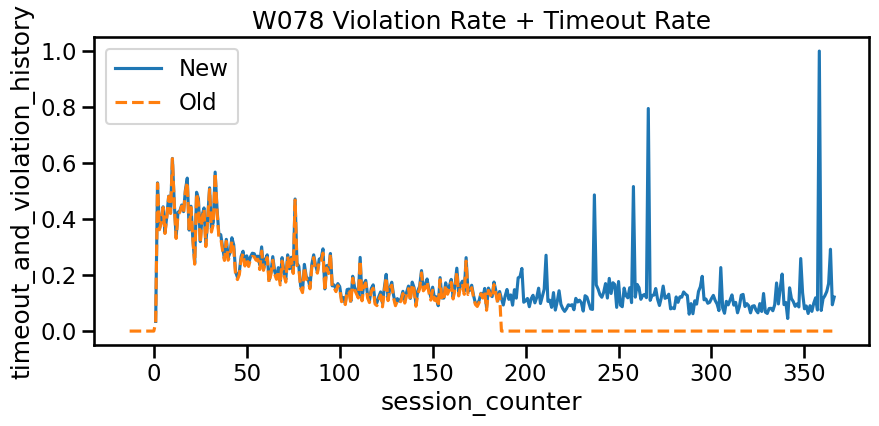

In [308]:
fig, ax = plt.subplots(
    figsize=(10, 4),
)

sns.lineplot(
    data=ndf,
    x="session_counter",
    y="timeout_and_violation_history",
    ax=ax,
    errorbar=None,
    label="New",
)
sns.lineplot(
    data=odf,
    x="session_align",
    y="violation",
    ax=ax,
    errorbar=None,
    label="Old",
    ls="--",
)
plt.title("W078 Violation Rate + Timeout Rate")

Okay, now what I would like to do is look at the session average violation rate across three datasets: odf, ndf and ndf without timeout trials to see how much it actually differs. The hue can be the training stage if we'd like.

In [317]:
ndf_no_timeout = (
    ndf.query("timeout_history != 1")
    .groupby("session_counter")
    .apply(add_trial_column)
    .reset_index(drop=True)
)

ndf_no_timeout["source"] = "new no TO"

In [318]:
assert (
    ndf.trial.max() != ndf_no_timeout.trial.max()
), "ERROR: TIMEOUT DF TRIALS MISCOUNTED"

In [358]:
session_avg_viols = (
    odf.groupby(["source", "training_stage", "session_align"])
    .violation.mean()
    .reset_index()
)

session_avg_viols.rename(
    columns={"violation": "violation_history", "session_align": "session_counter"},
    inplace=True,
)
new_session_avg_viols = (
    ndf.groupby(["source", "training_stage", "session_counter"])
    .violation_history.mean()
    .reset_index()
)

new_session_avg_viols = pd.concat(
    [
        new_session_avg_viols,
        ndf_no_timeout.groupby(["source", "training_stage", "session_counter"])
        .violation_history.mean()
        .reset_index(),
    ]
)

session_avg_viols = pd.concat([session_avg_viols, new_session_avg_viols])

In [359]:
print("old", vdf.groupby("session").violation.mean().mean())
print("new", ndf.groupby("session_counter").violation_history.mean().mean())
print("new", ndf_no_timeout.groupby("session_counter").violation_history.mean().mean())

old 0.2037968925328923
new 0.14307449649651344
new 0.15259619758026752


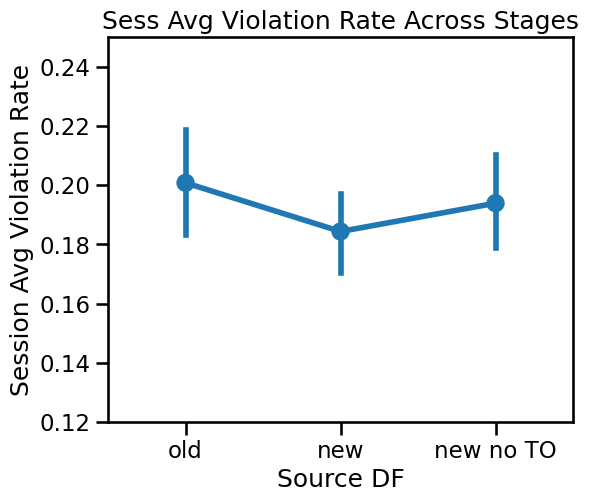

In [375]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(
    data=session_avg_viols.query("session_counter < 190"),
    x="source",
    y="violation_history",
    dodge=True,
    ax=ax,
)

_ = ax.set(
    xlabel="Source DF",
    ylabel="Session Avg Violation Rate",
    title="Sess Avg Violation Rate Across Stages",
    ylim=(0.12, 0.25),
)

<Axes: xlabel='source', ylabel='violation_history'>

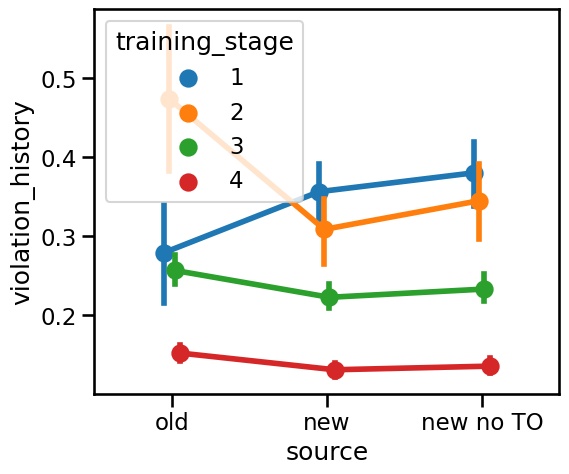

In [361]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(
    data=session_avg_viols.query("session_counter < 190"),
    x="source",
    y="violation_history",
    hue="training_stage",
    dodge=True,
)

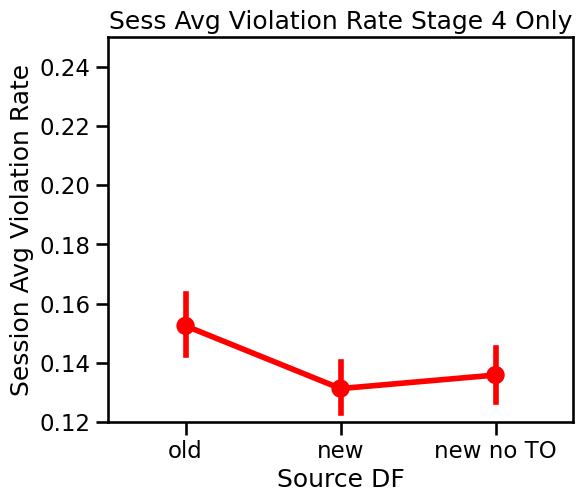

In [373]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(
    data=session_avg_viols.query("session_counter < 190").query("training_stage ==4"),
    x="source",
    y="violation_history",
    color="red",
    dodge=True,
)

_ = ax.set(
    xlabel="Source DF",
    ylabel="Session Avg Violation Rate",
    title="Sess Avg Violation Rate Stage 4 Only",
    ylim=(0.12, 0.25),
)

For comparison, I filtered for sessions less than 190 because I didn't want to compare to sessions in the old df where violations we not tracked. That would deflate the violation rate in odf and make for an unfair comparison.

These data show that the new df has a lower violation rate- this makes sense since the number of overall trials is not changing, but timeouts are no longer being counted as violations. 

The most important comparison here is the new no TO. This drops all timeout trials and gives a true representation of the violation rate. This is also lower than the old df. When only looking at stage 4, it shows that this change is minimal. This is likely because animals are more engaged, so there are fewer timeouts. It's approximately 2% lower. It will be interesting to see if this changes across animals.



### Violation ITIs

In [382]:
from violations_eda import create_trials_df_w_viol_iti

old_viol_iti_df = create_trials_df_w_viol_iti(
    animal_ids=[ANIMAL], min_stage=0, add_prev_viol_tau=False
)

""" Make viol ITI for new data"""
required_columns = ["rat_name", "session_counter", "trial", "violation_history"]
if not all([col in ndf_no_timeout.columns for col in required_columns]):
    raise ValueError(f"Required columns {required_columns} not present in DataFrame.")


# Function to apply to each animal-session group
def calculate_intervals(group):
    # Find trials with violations
    violation_trials = group["trial"][group["violation_history"] == 1]
    # Calculate intervals and shift to align with the next violation trial
    intervals = violation_trials.diff() - 1
    # Assign the calculated intervals back to the group
    group.loc[violation_trials.index, "violation_iti"] = intervals
    return group


# Initialize the violation_iti column
ndf_no_timeout["violation_iti"] = np.nan

# Apply the function to each animal-session group. Only adds iti values
# to the violation trials
new_viol_iti_df = ndf_no_timeout.groupby(["rat_name", "session_counter"]).apply(
    calculate_intervals
)

new_viol_iti_df = new_viol_iti_df.reset_index(drop=True)

returning viol data for ['W078']


In [395]:
old_viol_iti_df["source"] = "old"
old_viol_iti_df["session_counter"] = old_viol_iti_df["session"]
new_viol_iti_df["source"] = "new"
shared_cols = ["source", "session_counter", "training_stage", "violation_iti"]
violation_iti_combined = pd.concat(
    [old_viol_iti_df[shared_cols], new_viol_iti_df[shared_cols]]
).reset_index(drop=True)

Text(0.5, 1.0, 'W078 Stage 4 Violation ITI Distribution')

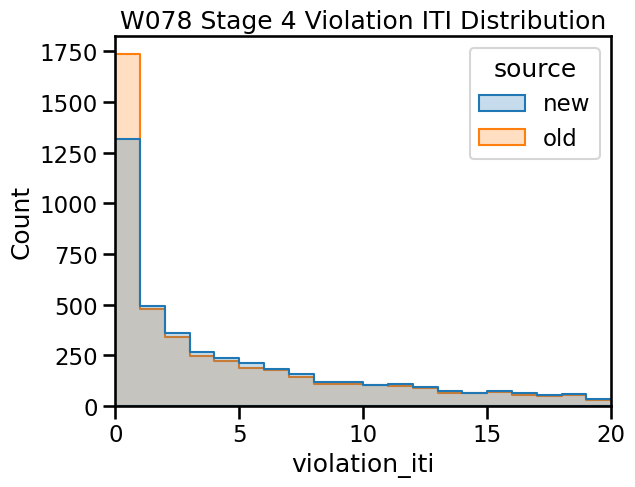

In [414]:
sns.histplot(
    data=violation_iti_combined.query("training_stage == 4 and session_counter < 200"),
    x="violation_iti",
    hue="source",
    hue_order=["new", "old"],
    binwidth=1,
    element="step",
)

plt.xlim(0, 20)
plt.title("W078 Stage 4 Violation ITI Distribution")